# Libs & APIs

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from dataclasses import dataclass
from typing import Dict, Tuple, List, Any
import warnings

warnings.filterwarnings('ignore')

In [17]:
plt.rcParams['figure.figsize'] = (10, 4)  # default plot sizes
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Model Config

In [18]:
@dataclass
class ModelConfig: # Dataclass for model configuration
    seq_length: int = 60 # Length of the sequence
    train_size: float = 0.7 # Train set size
    val_size: float = 0.2 # Validation set size
    features: List[str] = None # List of feature columns
    target: str = 'Close' # Target column
    
    def __post_init__(self):
        if self.features is None:
            self.features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Data Processing

In [ ]:
class StockDataProcessor: # Class for data processing
    def __init__(self, config: ModelConfig):
        self.config = config # Model configuration
        self.scaler = MinMaxScaler() # MinMaxScaler for scaling the data
        
    # Load and preprocess the data
    def load_and_preprocess_data(self, file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path) # Load the data
        df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime
        df = df.sort_values('Date') # Sort the data by date
        df = df[df['Date'].dt.year != 2005]  # Remove 2005 data
        return df.reset_index(drop=True) # Reset the index
    
    # Prepare the data
    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, pd.DatetimeIndex]:
        data = df[self.config.features].values # Extract the feature columns
        dates = df['Date'] # Extract the date column
        scaled_data = self.scaler.fit_transform(data) # Scale the data
        return scaled_data, dates, self.split_data(scaled_data, dates) # Split the data
    
    # Split the data into train, validation, and test sets
    def split_data(self, scaled_data: np.ndarray, dates: pd.DatetimeIndex) -> Dict:
        total_size = len(scaled_data) # Total number of samples
        train_size = int(total_size * self.config.train_size) # Train set size
        val_size = int(total_size * self.config.val_size) # Validation set size
        
        # Create overlapping segments to avoid gaps
        train_end = train_size + self.config.seq_length
        val_end = train_size + val_size + self.config.seq_length
        
        return {
            'train': (scaled_data[:train_end], dates[:train_end]),  
            'val': (scaled_data[train_size-self.config.seq_length:val_end], 
                   dates[train_size-self.config.seq_length:val_end]),
            'test': (scaled_data[val_end-self.config.seq_length:], 
                    dates[val_end-self.config.seq_length:])
        }
    
    # Create sequences for the model
    def create_sequences(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        X, y = [], [] # Initialize empty lists for sequences
        target_idx = self.config.features.index(self.config.target) # Index of the target column
        
        for i in range(len(data) - self.config.seq_length): 
            X.append(data[i:i + self.config.seq_length])
            y.append(data[i + self.config.seq_length, target_idx])
            
        return np.array(X), np.array(y)
    
    # Inverse transform the scaled values
    def inverse_transform_values(self, values: np.ndarray) -> np.ndarray:
        dummy = np.zeros((len(values), len(self.config.features))) # Create a dummy array
        target_idx = self.config.features.index(self.config.target) # Index of the target column
        dummy[:, target_idx] = values.flatten() # Assign the target values
        return self.scaler.inverse_transform(dummy)[:, target_idx] # Inverse transform the values

# Build Model

In [20]:
class ModelBuilder: # Class for building the model
    @staticmethod
    def create_model(model_type: str, seq_length: int, n_features: int) -> Sequential: # Create the model
        models = {
            'SimpleRNN': lambda: Sequential([
                SimpleRNN(64, input_shape=(seq_length, n_features), return_sequences=True), # First layer with 64 units and return sequences set to True
                Dropout(0.2), # Dropout layer to prevent overfitting
                SimpleRNN(32), # Second layer with 32 units
                Dropout(0.2),
                Dense(16, activation='relu'),  # Dense layer with 16 units and ReLU activation
                Dense(1) # Output layer with 1 unit for regression
            ]),
            'LSTM': lambda: Sequential([
                LSTM(64, input_shape=(seq_length, n_features), return_sequences=True), # First layer with 64 units and return sequences set to True
                Dropout(0.2), # Dropout layer to prevent overfitting
                LSTM(32), # Second layer with 32 units 
                Dropout(0.2),
                Dense(16, activation='relu'), # Dense layer with 16 units and ReLU activation
                Dense(1)
            ]),
            'GRU': lambda: Sequential([
                GRU(64, input_shape=(seq_length, n_features), return_sequences=True), # First layer with 64 units and return sequences set to True
                Dropout(0.2), # Dropout layer to prevent overfitting
                GRU(32), # Second layer with 32 units
                Dropout(0.2),
                Dense(16, activation='relu'), # Dense layer with 16 units and ReLU activation
                Dense(1)
            ])
        }
        return models[model_type]() # Return the model

# Training Model

In [ ]:
class ModelTrainer: # Class for training the model
    def __init__(self, config: ModelConfig): # Initialize the class
        self.config = config # Model configuration
        self.callbacks = [ # List of callbacks for training the model
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Early stopping callback to prevent overfitting
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6) # Reduce learning rate on plateau to improve convergence
        ]
    
    # Train the model and return the trained model and history
    def train_model(self, model: Sequential, X_train: np.ndarray, y_train: np.ndarray, 
                   X_val: np.ndarray, y_val: np.ndarray) -> Tuple[Sequential, Any]:
        model.compile(optimizer='adam', loss='mean_squared_error') # Compile the model with Adam optimizer and MSE loss
        history = model.fit( # Fit the model to the data
            X_train, y_train,
            epochs=50, # Number of epochs 
            batch_size=32, # Batch size
            validation_data = (X_val, y_val), # Validation data
            callbacks = self.callbacks, # List of callbacks
            verbose=1 # Set verbose to 1 to display the training progress bar
        )
        return model, history

# Visualization

In [27]:
class Visualizer: # Class for visualization
    @staticmethod
    def plot_predictions(dates: Dict[str, np.ndarray], actual: Dict[str, np.ndarray],  
                        pred: Dict[str, np.ndarray], model_name: str): # Plot the predictions 
        plt.figure(figsize=(15, 6))
        colors = {'train': '#1f77b4', 'val': '#2ca02c', 'test': '#d62728'}
        
        for set_name in ['train', 'val', 'test']:
            plt.plot(dates[set_name], actual[set_name], 
                    label=f'{set_name.capitalize()} (Actual)', 
                    color=colors[set_name], alpha=0.7)
            plt.plot(dates[set_name], pred[set_name], 
                    label=f'{set_name.capitalize()} (Predicted)', 
                    color=colors[set_name], alpha=0.3)
        
        plt.title(f'{model_name} - Stock Price Predictions')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Set the legend position to the right
        plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Set x-ticks to show every year
        plt.xticks(rotation=45) # Rotate x-ticks for better readability
        plt.tight_layout()
        plt.show()

    # Plot training and validation loss/accuracy.
    @staticmethod
    def plot_training_history(history, model_name: str):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history.history['loss'], label='Training Loss', color='#1f77b4')
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='#2ca02c')
        ax1.set_title(f'{model_name} - Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot accuracy
        train_acc = 100 * (1 - np.sqrt(history.history['loss']))
        val_acc = 100 * (1 - np.sqrt(history.history['val_loss']))
        
        ax2.plot(train_acc, label='Training Accuracy', color='#1f77b4')
        ax2.plot(val_acc, label='Validation Accuracy', color='#2ca02c')
        ax2.set_title(f'{model_name} - Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Calculating Metrics

In [30]:
class MetricsCalculator: # Class for calculating metrics
    @staticmethod
    def calculate_metrics(actual: np.ndarray, predicted: np.ndarray) -> Dict[str, float]:
        mse = np.mean((actual - predicted) ** 2) # Calculate MSE
        rmse = np.sqrt(mse) # Calculate RMSE
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100 # Calculate MAPE (Mean Absolute Percentage Error)
        accuracy = 100 - mape  # Accuracy as 100 - MAPE
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'accuracy': accuracy
        }
    
    # Print the metrics for each dataset
    @staticmethod
    def print_metrics(metrics: Dict[str, Dict[str, float]], model_name: str): 
        print(f"\n{'-'*50}") # Print a separator line 
        print(f"{model_name} Performance Metrics:")
        print(f"{'-'*50}")
        
        # Iterate through the datasets
        for set_name in ['train', 'val', 'test']: 
            print(f"\n{set_name.capitalize()} Set:")
            print(f"MSE: {metrics[set_name]['mse']:.4f}")
            print(f"RMSE: {metrics[set_name]['rmse']:.4f}")
            print(f"MAPE: {metrics[set_name]['mape']:.2f}%")
            print(f"Accuracy: {metrics[set_name]['accuracy']:.2f}%")

# Main Process

In [ ]:
def main():
    # Initialize configuration
    config = ModelConfig()
    
    # Initialize components
    processor = StockDataProcessor(config) # Initialize data processor
    trainer = ModelTrainer(config)      # Initialize model trainer
    visualizer = Visualizer()          # Initialize visualizer
    
    # Load and prepare data
    df = processor.load_and_preprocess_data('./data/AAL.csv') 
    scaled_data, dates, split_data = processor.prepare_data(df) # Prepare the data and split it into train, validation, and test sets
    
    # Process each data segment
    sequences = {}
    for set_name in ['train', 'val', 'test']:
        X, y = processor.create_sequences(split_data[set_name][0])
        sequences[set_name] = (X, y, split_data[set_name][1][config.seq_length:])
    
    # Train models
    models = ['SimpleRNN', 'LSTM', 'GRU'] # List of models to train 
    results = {}
    
    for model_name in models:
        print(f"\nTraining {model_name}...")
        model = ModelBuilder.create_model(model_name, config.seq_length, len(config.features)) # Create the model 
        
        # Train model
        trained_model, history = trainer.train_model(
            model,
            sequences['train'][0], sequences['train'][1],
            sequences['val'][0], sequences['val'][1]
        )

        # Plot training history
        visualizer.plot_training_history(history, model_name)
        
        # Make predictions
        predictions = {} # Initialize empty dictionary for predictions
        actuals = {} # Initialize empty dictionary for actual values
        dates_dict = {} # Initialize empty dictionary for dates
        
        metrics = {} # Initialize empty dictionary for metrics
        for set_name in ['train', 'val', 'test']:
            pred = trained_model.predict(sequences[set_name][0], verbose=0) # Make predictions on the data
            pred_transformed = processor.inverse_transform_values(pred) # Inverse transform the predicted values 
            actual_transformed = processor.inverse_transform_values(sequences[set_name][1]) # Inverse transform the actual values
            # Calculate metrics
            metrics[set_name] = MetricsCalculator.calculate_metrics(actual_transformed, pred_transformed) 
            
            predictions[set_name] = pred_transformed # Store the predictions
            actuals[set_name] = actual_transformed # Store the actual values
            dates_dict[set_name] = sequences[set_name][2]   # Store the dates

        # Print metrics
        MetricsCalculator.print_metrics(metrics, model_name)

        # Visualize results
        visualizer.plot_predictions(dates_dict, actuals, predictions, model_name)
        
        # Store results
        results[model_name] = {
            'model': trained_model,
            'history': history,
            'predictions': predictions,
            'actuals': actuals,
            'metrics': metrics
        }
    # After all models are trained, compare their performance:
    print("\nModel Comparison Summary:")
    print("-" * 50)
    for model_name, result in results.items():
        val_accuracy = result['metrics']['val']['accuracy'] # Get validation accuracy
        test_accuracy = result['metrics']['test']['accuracy'] # Get test accuracy
        print(f"\n{model_name}:")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Save best model
    best_model_name = max(results.items(), key=lambda x: x[1]['metrics']['val']['accuracy'])[0]
    
    results[best_model_name]['model'].save(f'best_model_{best_model_name}.h5')
    print(f"\nBest Model ({best_model_name}) saved successfully!")


Training SimpleRNN...
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1160 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0120 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0013 - learning_rate: 0.0

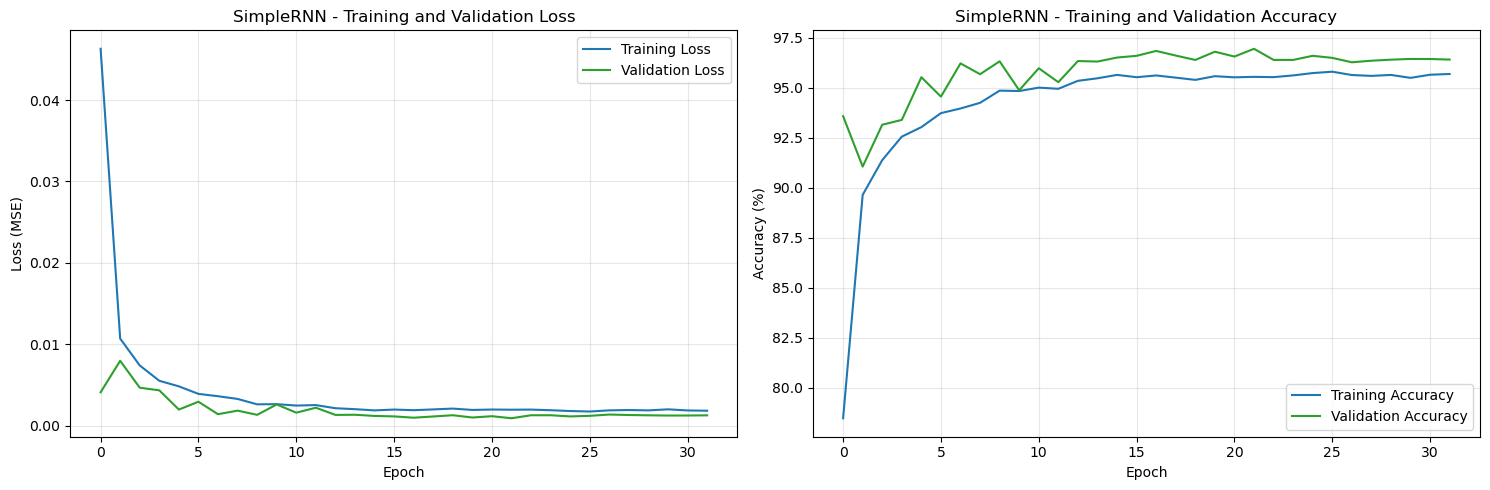


--------------------------------------------------
SimpleRNN Performance Metrics:
--------------------------------------------------

Train Set:
MSE: 2.8215
RMSE: 1.6797
MAPE: 6.09%
Accuracy: 93.91%

Val Set:
MSE: 3.4657
RMSE: 1.8616
MAPE: 5.98%
Accuracy: 94.02%

Test Set:
MSE: 1.5943
RMSE: 1.2627
MAPE: 5.99%
Accuracy: 94.01%


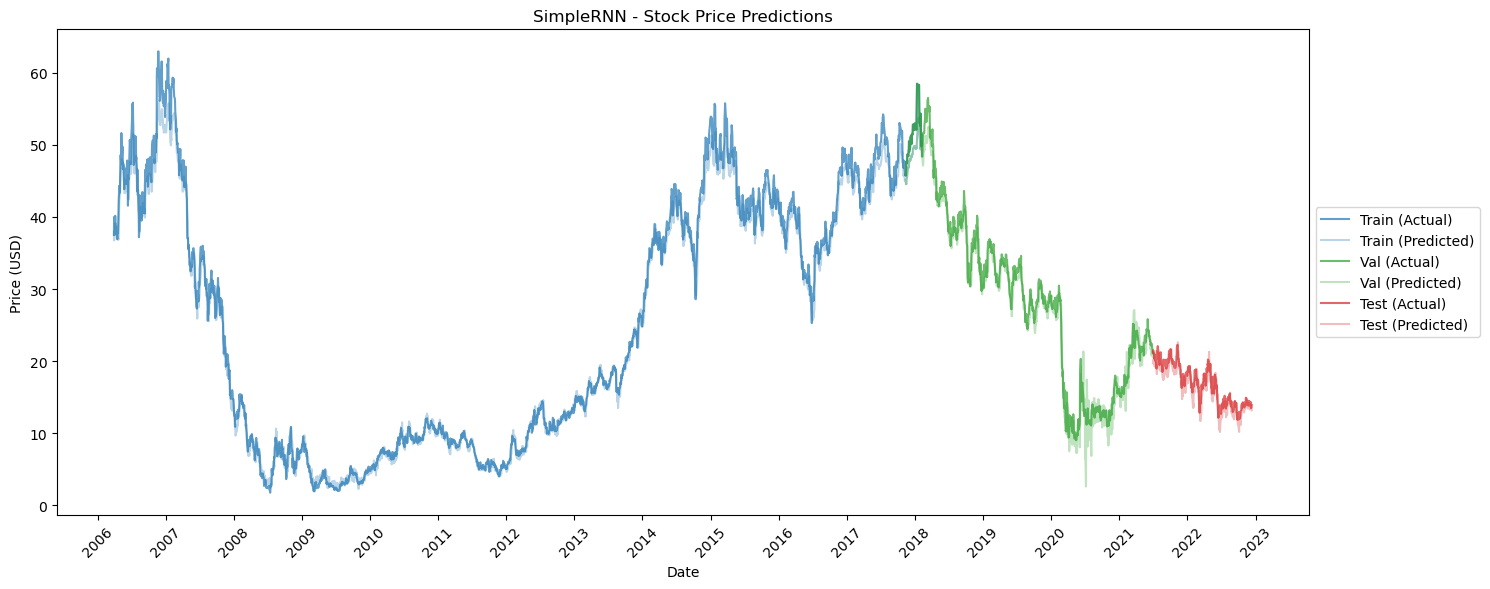


Training LSTM...
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0571 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0034 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0032 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0029 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0026 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0022 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0019 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 1.00

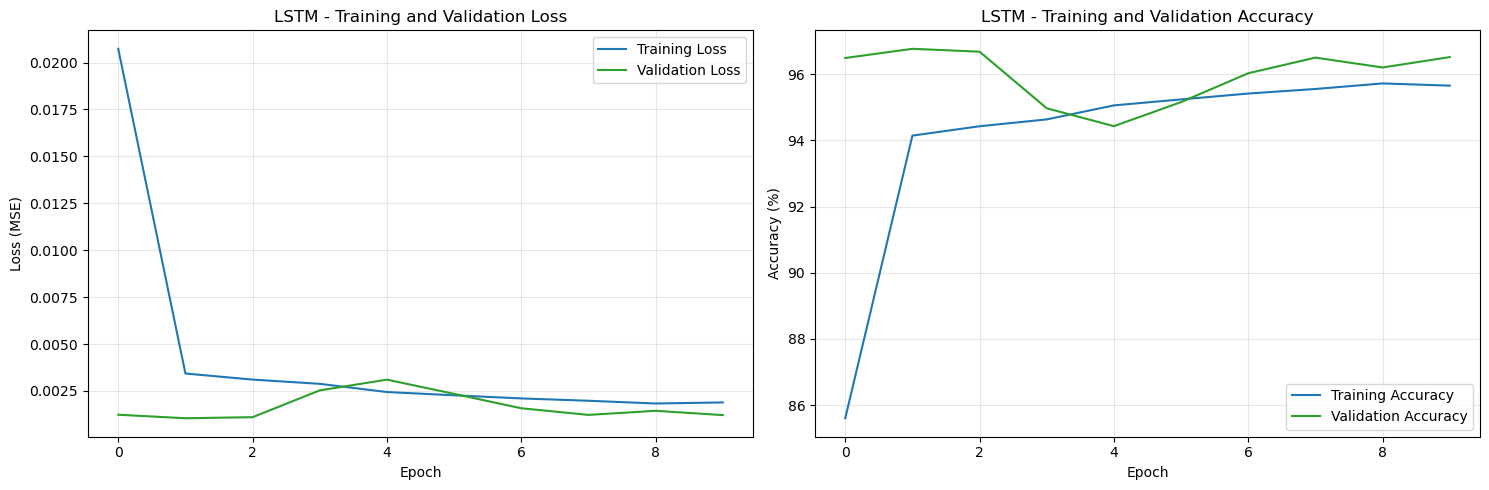


--------------------------------------------------
LSTM Performance Metrics:
--------------------------------------------------

Train Set:
MSE: 3.6401
RMSE: 1.9079
MAPE: 8.63%
Accuracy: 91.37%

Val Set:
MSE: 4.6068
RMSE: 2.1463
MAPE: 6.35%
Accuracy: 93.65%

Test Set:
MSE: 1.4279
RMSE: 1.1949
MAPE: 5.81%
Accuracy: 94.19%


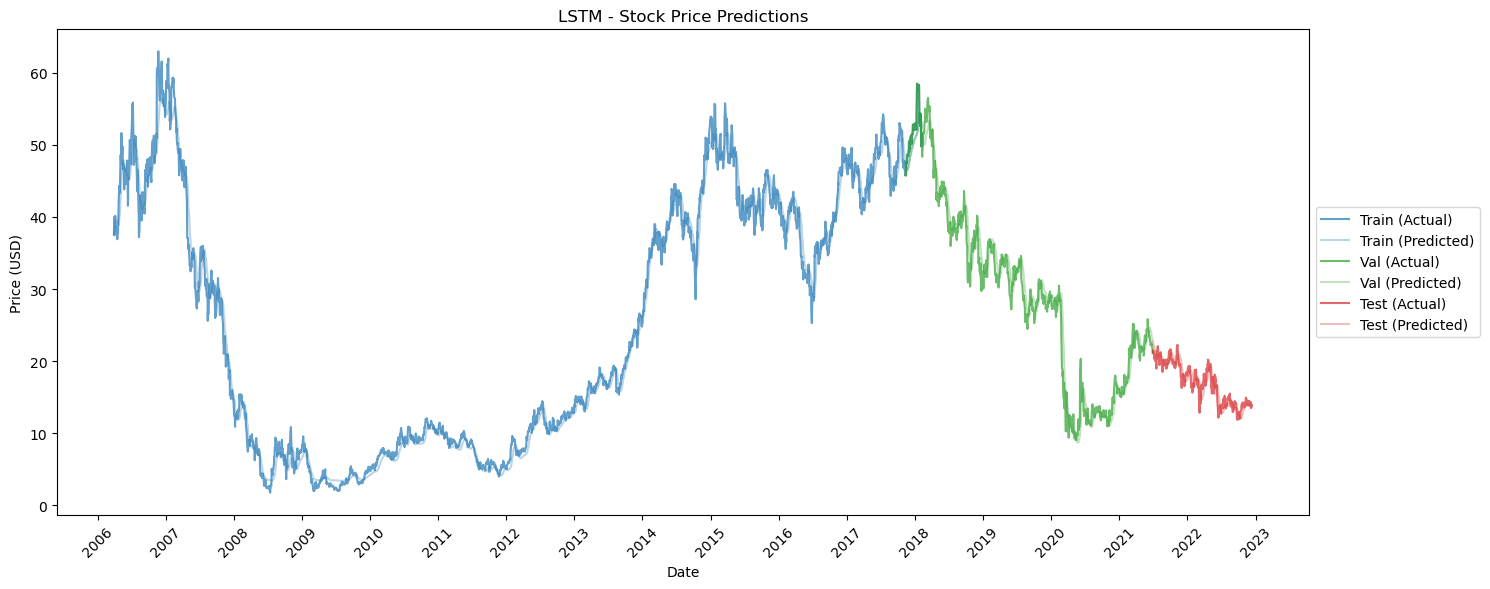


Training GRU...
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0372 - val_loss: 9.8150e-04 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0040 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0028 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0025 - val_loss: 9.9292e-04 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 0.0013 - learning

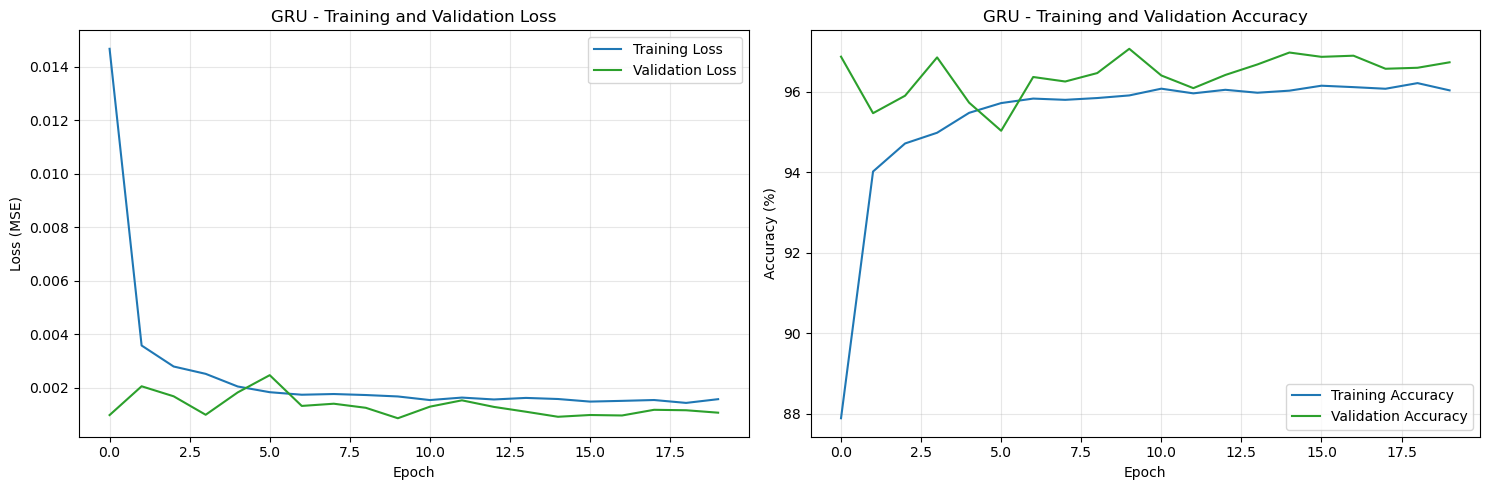


--------------------------------------------------
GRU Performance Metrics:
--------------------------------------------------

Train Set:
MSE: 3.4315
RMSE: 1.8524
MAPE: 6.30%
Accuracy: 93.70%

Val Set:
MSE: 3.2313
RMSE: 1.7976
MAPE: 5.18%
Accuracy: 94.82%

Test Set:
MSE: 0.9814
RMSE: 0.9906
MAPE: 4.62%
Accuracy: 95.38%


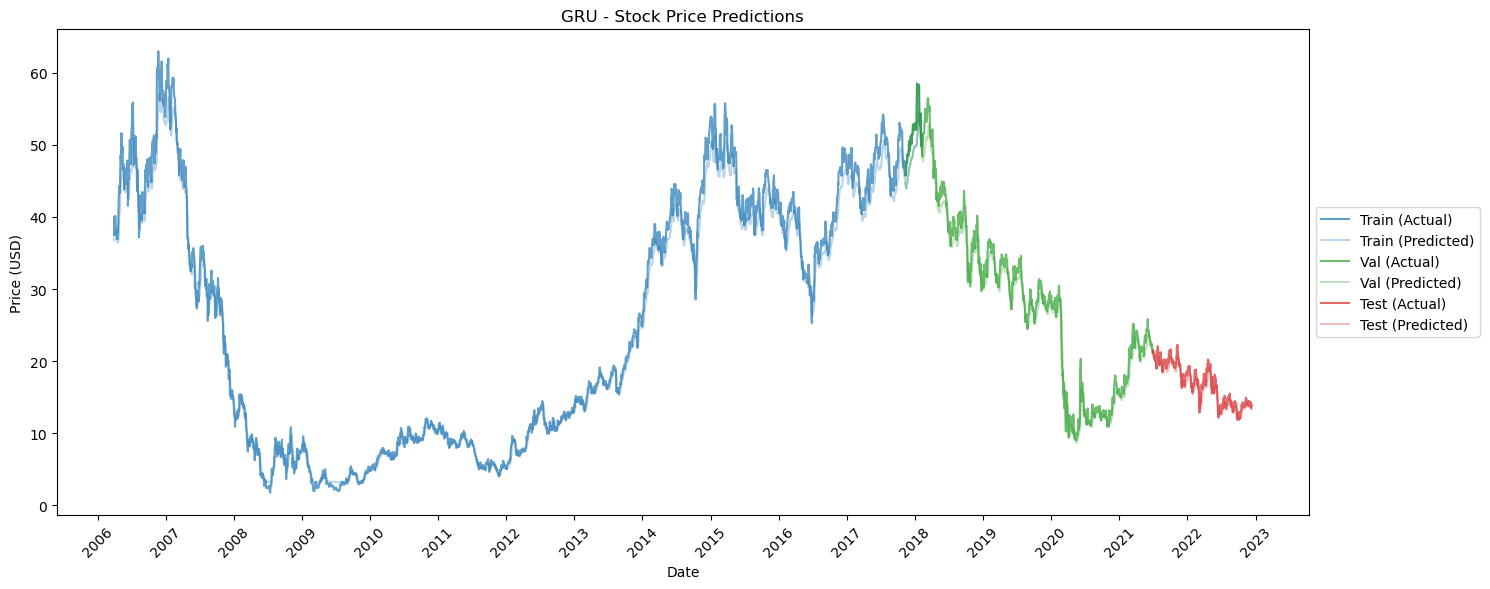


Model Comparison Summary:
--------------------------------------------------

SimpleRNN:
Validation Accuracy: 94.02%
Test Accuracy: 94.01%

LSTM:
Validation Accuracy: 93.65%
Test Accuracy: 94.19%

GRU:
Validation Accuracy: 94.82%
Test Accuracy: 95.38%

Best Model (GRU) saved successfully!


In [36]:
if __name__ == '__main__':
    main()